## Desafío combinatorio en 2D

Problema no puede resolverse por fuerza bruta.
Descripción:
Lattice 2D 10x10, configuración inicial tiene:
* 84 átomos de Fe.
* 16 átomos de R, en el cuadrado central con posiciones $(x,y)$, $x,y \in \{3,4,5,6\}$.

Encontrar la configuración óptima de colocar 8 átomos de Titanio (Ti) en los sitios de Fe.

In [ ]:
import math
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

LATTICE_SPACING = 2.8    # <--- ESPACIAMIENTO CORRECTO

# Parámetros del potencial de Morse (D0, alpha, r0)
MORSE_PARAMS = {
    ('Fe', 'Fe'): {'D0': 0.764, 'alpha': 1.5995, 'r0': 2.7361},
    ('Fe', 'R'):  {'D0': 0.6036, 'alpha': 1.6458, 'r0': 3.188},
    ('R', 'R'):   {'D0': 0.312, 'alpha': 0.945, 'r0': 4.092},
    ('Fe', 'Ti'): {'D0': 0.8162, 'alpha': 1.448, 'r0': 2.914},
    ('R', 'Ti'):  {'D0': 0.4964, 'alpha': 1.4401, 'r0': 3.4309},
    ('Ti', 'Ti'): {'D0': 0.6540, 'alpha': 1.2118, 'r0': 3.3476},
}

def get_morse_params_any_order(a, b):
    if (a,b) in MORSE_PARAMS: return MORSE_PARAMS[(a,b)]
    if (b,a) in MORSE_PARAMS: return MORSE_PARAMS[(b,a)]
    raise KeyError(f"No params for ({a},{b})")

def morse_potential(r, D0, alpha, r0):
    x = math.exp(-alpha*(r-r0))
    return D0*(x*x - 2*x)

# ---------------------------------------------------------
#  RED 10×10 (R EN EL CUADRADO CENTRAL)
# ---------------------------------------------------------
def build_lattice():
    atom_types = []
    coords = []
    grid_coords = []
    # Recordar que contamos desde 0
    r_positions = {(3,3),(3,4),(3,5),(3,6),(4,3),(4,4),(4,5),(4,6),(5,3),(5,4),(5,5),(5,6),(6,3),(6,4),(6,5),(6,6)}
    for y in range(10):
        for x in range(10):
            coords.append([x*LATTICE_SPACING, y*LATTICE_SPACING])
            grid_coords.append((x, y))
            atom_types.append("R" if (x,y) in r_positions else "Fe")
    
    return np.array(coords, dtype=float), atom_types, grid_coords

# ---------------------------------------------------------
# MATRIZ DE DISTANCIAS
# ---------------------------------------------------------
def build_distance_matrix(coords):
    n = len(coords)
    dist_matrix = np.zeros((n,n))
    for i in range(n):
        xi, yi = coords[i]
        for j in range(i+1,n):
            xj, yj = coords[j]
            r = math.hypot(xi-xj, yi-yj)
            dist_matrix[i,j] = r
            dist_matrix[j,i] = r
    return dist_matrix

def calculate_energy(dist_matrix, atom_types):
    """Calcula E_total = Σ_i Σ_{j>i} U_ij(r_ij)"""
    n = len(atom_types)
    total = 0.0
    for i in range(n):
        for j in range(i + 1, n):
            r = dist_matrix[i, j]
            p = get_morse_params_any_order(atom_types[i], atom_types[j])
            total += morse_potential(r, p['D0'], p['alpha'], p['r0'])
    return total


def get_fe_indices(atom_types):
    """Retorna índices de átomos Fe (candidatos para sustitución)."""
    return [i for i, atom in enumerate(atom_types) if atom == 'Fe']


def get_neighbors(grid_coord, grid_size=10):  # Cambiar a 10
    """
    Retorna los vecinos de una posición en la grilla 10x10.
    """
    x, y = grid_coord
    neighbors = []
    
    # Vecinos ortogonales
    for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < grid_size and 0 <= ny < grid_size:
            neighbors.append((nx, ny))
    
    return neighbors


def substitute_ti(atom_types, ti_indices):
    """Crea una nueva configuración atómica con Ti en las posiciones especificadas.
    
    Args:
        atom_types (list): Lista original de tipos de átomos
        ti_indices (list): Lista de índices donde colocar átomos de Ti
        
    Returns:
        list: Nueva lista de tipos de átomos con Ti en las posiciones especificadas"""
    new_types = atom_types.copy()
    for idx in ti_indices:
        new_types[idx] = 'Ti'
    return new_types

def get_fe_indices(atom_types):
    """Retorna índices de átomos Fe (candidatos para sustitución)."""
    return [i for i, atom in enumerate(atom_types) if atom == 'Fe']

# =============================================================================
# RECOCIDO SIMULADO - IMPLEMENTACIÓN CORRECTA
# =============================================================================
def simulated_annealing(dist_matrix, atom_types, grid_coords,
                        T_initial=5.0, T_final=0.001,
                        cooling_rate=0.95, steps_per_temp=50,
                        cooling_schedule='exponential',
                        neighbor_only=True,
                        verbose=False):
    """
    Algoritmo de Recocido Simulado para optimizar la posición de 8 átomos de Ti
    en una red cristalina de Fe con impurezas R.
    
    Args:
        dist_matrix (ndarray): Matriz de distancias precalculada entre todos los átomos
        atom_types (list): Lista de tipos de átomos ['Fe', 'R', ...] para la configuración inicial
        grid_coords (list): Lista de coordenadas de grilla (x,y) para cada átomo
        T_initial (float): Temperatura inicial del recocido (default: 5.0)
        T_final (float): Temperatura final para criterio de parada (default: 0.001)
        cooling_rate (float): Tasa de enfriamiento para esquema exponencial (default: 0.95)
        steps_per_temp (int): Número de pasos de Monte Carlo por temperatura (default: 50)
        cooling_schedule (str): Esquema de enfriamiento: 
            'exponential' - T *= cooling_rate
            'linear' - T -= ΔT lineal  
            'logarithmic' - T = T0/(1+ln(1+k)) (default: 'exponential')
        neighbor_only (bool): Si True, restringe movimientos a sitios Fe vecinos;
            si False, permite saltos a cualquier sitio Fe (default: True)
        verbose (bool): Si True, imprime progreso durante la ejecución (default: False)
    
    Returns:
        tuple: (best_ti_indices, best_energy, energy_history, temp_history)
        
        best_ti_indices (list): Lista de 8 índices óptimos para los átomos de Ti
        best_energy (float): Energía mínima encontrada en la configuración óptima
        energy_history (list): Historial de energías en cada paso del algoritmo
        temp_history (list): Historial de temperaturas en cada paso del algoritmo
    """
    fe_indices = get_fe_indices(atom_types)
    
    # Crear mapeo de índice a coordenada de grilla y viceversa
    idx_to_grid = {i: grid_coords[i] for i in fe_indices}
    grid_to_idx = {grid_coords[i]: i for i in fe_indices}
    
    # Estado inicial: 8 posiciones aleatorias de Fe
    current_ti_indices = random.sample(fe_indices, 8)
    current_types = substitute_ti(atom_types, current_ti_indices)
    current_energy = calculate_energy(dist_matrix, current_types)
    
    # Mejor solución encontrada
    best_ti_indices = current_ti_indices.copy()
    best_energy = current_energy
    
    # Historiales para análisis
    energy_history = [current_energy]
    temp_history = [T_initial]
    
    T = T_initial
    iteration = 0
    max_iterations = 200
    
    # Calcular número de iteraciones para esquema lineal
    if cooling_schedule == 'linear':
        n_temp_steps = int(np.ceil(np.log(T_final / T_initial) / np.log(cooling_rate)))
        delta_T = (T_initial - T_final) / max(n_temp_steps, 1)
    
    while T > T_final and iteration < max_iterations:
        accepted = 0
        
        for _ in range(steps_per_temp):
            # PROPONER NUEVO ESTADO: mover uno de los 8 átomos de Ti
            proposed_ti_indices = current_ti_indices.copy()
            
            # Elegir un átomo de Ti aleatorio para mover
            ti_to_move_idx = random.randint(0, 7)
            ti_to_move = current_ti_indices[ti_to_move_idx]
            
            if neighbor_only:
                # Movimiento realista: solo a sitios Fe vecinos
                current_grid = idx_to_grid[ti_to_move]
                neighbor_grids = get_neighbors(current_grid, grid_size=10)  # Cambiar a 10
                
                # Filtrar solo vecinos que son Fe y no son ya Ti
                fe_neighbor_grids = [g for g in neighbor_grids 
                                   if g in grid_to_idx and 
                                   grid_to_idx[g] not in current_ti_indices]
                
                if not fe_neighbor_grids:
                    # Si no hay vecinos Fe, permitir cualquier sitio Fe no ocupado
                    available_fe = [i for i in fe_indices if i not in current_ti_indices]
                    if available_fe:
                        new_ti_pos = random.choice(available_fe)
                    else:
                        continue  # No hay movimientos posibles
                else:
                    proposed_grid = random.choice(fe_neighbor_grids)
                    new_ti_pos = grid_to_idx[proposed_grid]
            else:
                # Movimiento no realista: cualquier sitio Fe no ocupado
                available_fe = [i for i in fe_indices if i not in current_ti_indices]
                if not available_fe:
                    continue
                new_ti_pos = random.choice(available_fe)
            
            # Reemplazar la posición del Ti movido
            proposed_ti_indices[ti_to_move_idx] = new_ti_pos
            
            # Calcular energía del estado propuesto
            proposed_types = substitute_ti(atom_types, proposed_ti_indices)
            proposed_energy = calculate_energy(dist_matrix, proposed_types)
            
            # CRITERIO DE METROPOLIS
            delta_E = proposed_energy - current_energy
            
            if delta_E < 0:
                accept = True
            else:
                accept = random.random() < np.exp(-delta_E / T)
            
            if accept:
                current_ti_indices = proposed_ti_indices
                current_types = proposed_types
                current_energy = proposed_energy
                accepted += 1
                
                # Actualizar mejor solución
                if current_energy < best_energy:
                    best_ti_indices = current_ti_indices.copy()
                    best_energy = current_energy
            
            energy_history.append(current_energy)
            temp_history.append(T)
        
        # ENFRIAMIENTO según esquema elegido
        if cooling_schedule == 'exponential':
            T *= cooling_rate
        elif cooling_schedule == 'linear':
            T -= delta_T
            T = max(T, T_final)
        elif cooling_schedule == 'logarithmic':
            iteration += 1
            T = T_initial / (1 + np.log(1 + iteration))
        
        if verbose and iteration % 20 == 0:
            accept_rate = accepted / steps_per_temp * 100
            print(f"  T={T:.4f}, E_actual={current_energy:.4f}, "
                  f"E_mejor={best_energy:.4f}, aceptación={accept_rate:.1f}%")
        
        iteration += 1
    
    return best_ti_indices, best_energy, energy_history, temp_history


def run_convergence_test(dist_matrix, atom_types, grid_coords, 
                         n_runs=20, **sa_params):
    """
    Ejecuta múltiples corridas de SA para 8 átomos de Ti.
    """
    results = []
    
    for i in range(n_runs):
        best_ti_indices, best_energy, _, _ = simulated_annealing(
            dist_matrix, atom_types, grid_coords, **sa_params
        )
        results.append({
            'indices': best_ti_indices,
            'grids': [grid_coords[idx] for idx in best_ti_indices],
            'energy': best_energy
        })
    
    # Estadísticas
    energies = [r['energy'] for r in results]
    
    # Encontrar configuraciones con energía mínima
    min_energy = min(energies)
    min_configs = [r for r in results if abs(r['energy'] - min_energy) < 1e-6]
    
    # Contar configuraciones únicas (basado en posiciones ordenadas)
    unique_configs = set()
    for config in min_configs:
        sorted_grids = tuple(sorted(config['grids']))
        unique_configs.add(sorted_grids)
    
    return {
        'results': results,
        'min_energy': min_energy,
        'mean_energy': np.mean(energies),
        'std_energy': np.std(energies),
        'unique_minima': len(unique_configs),
        'convergence_to_min': len(min_configs) / n_runs * 100
    }




  PARCIAL 2: RECOCIDO SIMULADO PARA OPTIMIZACIÓN DE DOPAJE CON Ti
  Red 2D 10x10 - Espaciado: 2.8

Configuración:
  - R (Neodimio) en: [(3, 3), (3, 4), (3, 5), (3, 6), (4, 3), (4, 4), (4, 5), (4, 6), (5, 3), (5, 4), (5, 5), (5, 6), (6, 3), (6, 4), (6, 5), (6, 6)]
  - 84 sitios de Fe disponibles para sustitución

----------------------------------------------------------------------
PARTE 1: Corrida individual detallada (Esquema Exponencial)
----------------------------------------------------------------------
  T=4.7500, E_actual=-121.8812, E_mejor=-122.8822, aceptación=96.7%
  T=1.7028, E_actual=-119.8294, E_mejor=-123.1584, aceptación=86.7%
  T=0.6104, E_actual=-122.3490, E_mejor=-123.4691, aceptación=73.3%
  T=0.2188, E_actual=-123.7750, E_mejor=-123.7849, aceptación=56.7%
  T=0.0784, E_actual=-123.7143, E_mejor=-123.7849, aceptación=26.7%
  T=0.0281, E_actual=-123.7435, E_mejor=-123.7849, aceptación=6.7%
  T=0.0101, E_actual=-123.7810, E_mejor=-123.7849, aceptación=0.0%
  T=0.003

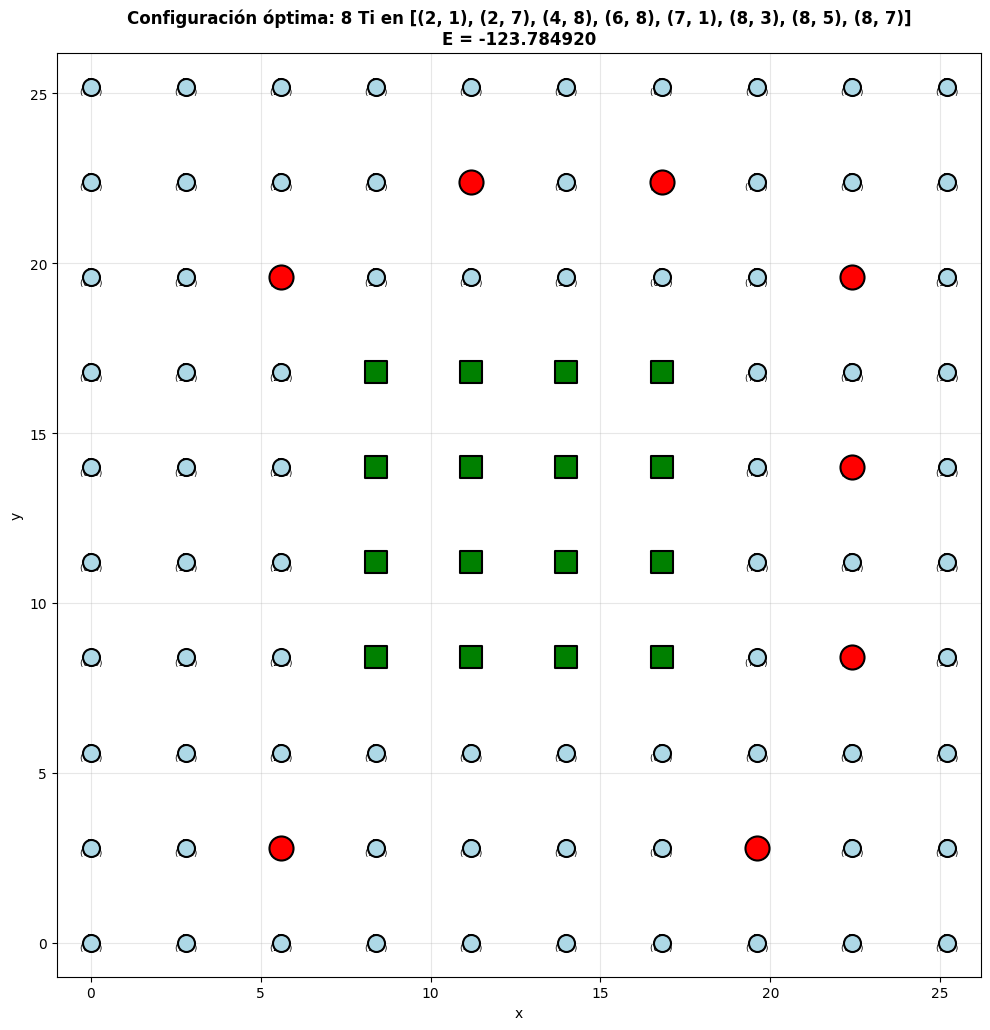


  COMPLETADO


In [13]:
# =============================================================================
# VISUALIZACIÓN
# =============================================================================
def plot_sa_evolution(energy_history, temp_history, title="Evolución del Recocido Simulado"):
    """Grafica la evolución de energía y temperatura."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    iterations = range(len(energy_history))
    
    ax1.plot(iterations, energy_history, 'b-', alpha=0.7, linewidth=0.5)
    ax1.axhline(y=min(energy_history), color='r', linestyle='--', 
                label=f'E_min = {min(energy_history):.4f}')
    ax1.set_ylabel('Energía', fontsize=12)
    ax1.set_title(title, fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(iterations, temp_history, 'r-', alpha=0.7)
    ax2.set_xlabel('Iteración', fontsize=12)
    ax2.set_ylabel('Temperatura', fontsize=12)
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def plot_convergence_comparison(results_dict):
    """Compara convergencia de diferentes esquemas."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    schemes = list(results_dict.keys())
    colors = ['blue', 'green', 'red', 'orange']
    
    # 1. Tasa de convergencia al mínimo
    conv_rates = [results_dict[s]['convergence_to_min'] for s in schemes]
    bars = axes[0].bar(schemes, conv_rates, color=colors[:len(schemes)], alpha=0.7)
    axes[0].set_ylabel('Convergencia al mínimo (%)')
    axes[0].set_title('Tasa de convergencia')
    axes[0].set_ylim(0, 105)
    for bar, rate in zip(bars, conv_rates):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{rate:.0f}%', ha='center')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # 2. Distribución de energías
    for i, scheme in enumerate(schemes):
        energies = [r['energy'] for r in results_dict[scheme]['results']]
        axes[1].hist(energies, bins=15, alpha=0.5, label=scheme, color=colors[i])
    axes[1].set_xlabel('Energía final')
    axes[1].set_ylabel('Frecuencia')
    axes[1].set_title('Distribución de energías')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    # 3. Energía media y desviación
    means = [results_dict[s]['mean_energy'] for s in schemes]
    stds = [results_dict[s]['std_energy'] for s in schemes]
    x = range(len(schemes))
    axes[2].bar(x, means, yerr=stds, color=colors[:len(schemes)], alpha=0.7, capsize=5)
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(schemes)
    axes[2].set_ylabel('Energía media ± std')
    axes[2].set_title('Energía promedio por esquema')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig


def plot_lattice_result(positions, atom_types, grid_coords, ti_indices, energy, r_positions):
    """Visualiza la red con 8 átomos de Ti."""
    fig, ax = plt.subplots(figsize=(12, 12))
    
    for i, (pos, atom) in enumerate(zip(positions, atom_types)):
        grid = grid_coords[i]
        
        if i in ti_indices:
            color, size, marker = 'red', 300, 'o'
            label = f'Ti\n{grid}'
        elif atom == 'R':
            color, size, marker = 'green', 250, 's'
            label = f'R\n{grid}'
        else:
            color, size, marker = 'lightblue', 150, 'o'
            label = f'Fe\n{grid}'
        
        ax.scatter(pos[0], pos[1], c=color, s=size, marker=marker,
                  edgecolors='black', linewidths=1.5, zorder=5)
        ax.annotate(label, (pos[0], pos[1]), ha='center', va='center', fontsize=6)
    
    # Ajustar límites para red 10x10
    max_coord = 9 * LATTICE_SPACING
    ax.set_xlim(-1, max_coord + 1)
    ax.set_ylim(-1, max_coord + 1)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    
    # Mostrar posiciones de Ti en el título
    ti_positions = [grid_coords[idx] for idx in ti_indices]
    ax.set_title(f'Configuración óptima: 8 Ti en {sorted(ti_positions)}\nE = {energy:.6f}',
                fontsize=12, fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    return fig


# =============================================================================
# PROGRAMA PRINCIPAL
# =============================================================================
def main():
    print("\n" + "=" * 70)
    print("  PARCIAL 2: RECOCIDO SIMULADO PARA OPTIMIZACIÓN DE DOPAJE CON Ti")
    print("  Red 2D 10x10 - Espaciado: 2.8")
    print("=" * 70)
    
    # Configuración de la red 10x10
    # R en un patrón central 4x4 en una red 10x10
    r_positions = {(3,3),(3,4),(3,5),(3,6),(4,3),(4,4),(4,5),(4,6),
                   (5,3),(5,4),(5,5),(5,6),(6,3),(6,4),(6,5),(6,6)}
    
    positions, atom_types, grid_coords = build_lattice()
    dist_matrix = build_distance_matrix(positions)
    
    print(f"\nConfiguración:")
    print(f"  - R (Neodimio) en: {sorted(r_positions)}")
    print(f"  - {100 - len(r_positions)} sitios de Fe disponibles para sustitución") 
    
    # =========================================================================
    # PARTE 1: Una corrida detallada con esquema exponencial
    # =========================================================================
    print("\n" + "-" * 70)
    print("PARTE 1: Corrida individual detallada (Esquema Exponencial)")
    print("-" * 70)
    
    best_ti_indices, best_energy, e_hist, t_hist = simulated_annealing(
        dist_matrix, atom_types, grid_coords,
        T_initial=5.0, T_final=0.001, cooling_rate=0.95,
        steps_per_temp=30, cooling_schedule='exponential',
        neighbor_only=True, verbose=True
    )
    
    ti_positions = [grid_coords[idx] for idx in best_ti_indices]
    print(f"\nResultado: 8 Ti en {sorted(ti_positions)}, E = {best_energy:.6f}")
    
    # =========================================================================
    # PARTE 2: Comparación de esquemas de enfriamiento
    # =========================================================================
    print("\n" + "-" * 70)
    print("PARTE 2: Comparación de esquemas de enfriamiento (10 corridas c/u)")
    print("-" * 70)
    
    n_runs = 10
    common_params = {
        'T_initial': 5.0,
        'T_final': 0.001,
        'steps_per_temp': 30,
        'neighbor_only': True
    }
    
    results = {}
    
    print("\n1. Esquema Exponencial (T *= 0.95)...")
    results['Exponencial'] = run_convergence_test(
        dist_matrix, atom_types, grid_coords, n_runs,
        cooling_rate=0.95, cooling_schedule='exponential', **common_params
    )
    
    print("2. Esquema Lineal (T -= ΔT)...")
    results['Lineal'] = run_convergence_test(
        dist_matrix, atom_types, grid_coords, n_runs,
        cooling_rate=0.95, cooling_schedule='linear', **common_params
    )
    
    print("3. Esquema Logarítmico (T = T0/(1+ln(1+k)))...")
    results['Logarítmico'] = run_convergence_test(
        dist_matrix, atom_types, grid_coords, n_runs,
        cooling_rate=0.95, cooling_schedule='logarithmic', **common_params
    )
    
    # =========================================================================
    # PARTE 3: Resumen de resultados
    # =========================================================================
    print("\n" + "=" * 70)
    print("RESUMEN DE RESULTADOS")
    print("=" * 70)
    
    print(f"\n{'Esquema':<15} {'Convergencia':<12} {'E_min':<12} {'E_media±std':<20} {'Mínimos únicos'}")
    print("-" * 75)
    
    for scheme, res in results.items():
        print(f"{scheme:<15} {res['convergence_to_min']:>8.0f}% "
              f"{res['min_energy']:>12.4f} "
              f"{res['mean_energy']:>8.4f}±{res['std_energy']:<8.4f} "
              f"{res['unique_minima']}")
    
    # Mejor resultado global
    best_global_energy = min(res['min_energy'] for res in results.values())
    best_scheme = [s for s, r in results.items() if r['min_energy'] == best_global_energy][0]
    
    print("-" * 75)
    print(f"\nMejor energía encontrada: {best_global_energy:.6f}")
    print(f"Mínimos equivalentes detectados: {results[best_scheme]['unique_minima']}")
    
    # =========================================================================
    # PARTE 4: Verificación de convergencia
    # =========================================================================
    print("\n" + "-" * 70)
    print("VERIFICACIÓN DE CONVERGENCIA")
    print("-" * 70)
    
    # Todos los esquemas deberían converger a la misma energía mínima
    energies_found = [res['min_energy'] for res in results.values()]
    
    if max(energies_found) - min(energies_found) < 1e-4:
        print("✓ TODOS los esquemas convergen a la MISMA energía mínima")
        print(f"  E_min = {best_global_energy:.6f}")
    else:
        print("⚠ Los esquemas convergen a diferentes mínimos:")
        for scheme, res in results.items():
            print(f"  {scheme}: E_min = {res['min_energy']:.6f}")
    
    # =========================================================================
    # GENERAR GRÁFICAS
    # =========================================================================
    print("\n" + "-" * 70)
    print("Generando visualización...")
    
    # Configuración óptima
    fig3 = plot_lattice_result(positions, atom_types, grid_coords, 
                               best_ti_indices, best_energy, r_positions)
    fig3.savefig('optimal_config_8Ti.png', dpi=150, bbox_inches='tight')
    print("  → optimal_config_8Ti.png")
    
    plt.show()
    
    print("\n" + "=" * 70)
    print("  COMPLETADO")
    print("=" * 70)
    
    return results


if __name__ == "__main__":
    # No fijar semilla para aleatoriedad real
    main()